In [426]:
import pandas as pd
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os

%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False 


def readDeathData(country):
    """
    Liest Daten ueber die Anzahl der Tote aus
    :param country: Land
    :return: ausgelesene Daten
    """
    death_data = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
    data = death_data[(death_data['Country/Region'] == country)].iloc[:,4:]
    return data.sum()

def readConfirmedData(country):
    """
    liest die Daten ueber die Anzahl der Infizierten ein
    :param country: Land
    :return: ausgelesene Daten
    """
    recover_data = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
    data = recover_data[(recover_data['Country/Region'] == country)].iloc[:,4:]
    return data.sum()

def readRecoveredData(country):
    """
    liest die Daten ueber die Anzahl der Genesenen ein
    :param country: Land
    :return: ausgelesene Daten
    """
    recover_data = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
    data = recover_data[(recover_data['Country/Region'] == country)].iloc[:,4:]
    return data.sum()

In [427]:
#Populationsstand verschiedener Laender
popu_dict = {'Germany':82927922, 'Italy':60482200}

def load_IR(name, N, t,T=None):
    """
    Laedt die Daten der Faelle, Genesenen und Toten
    :param name: Das zu betrachtende Land
    :param N: Gesamtpopulation
    :param t: Startzeitpunkt
    :param T: Endzeitpunkt (optional)
    :return: Aktive Infizierte, Genesen, Tote, gesamte Faelle
    """
    #T=163

    R = readRecoveredData(name)
    D = readDeathData(name)
    C = readConfirmedData(name)
    R = R.tolist()[t:T]
    D = D.tolist()[t:T]
    C = C.tolist()[t:T]
    R = np.array(R)
    D = np.array(D)
    C = np.array(C)
    I = C - R - D
    return I,R,D,C

def SSE(I_t, I):
    """
    Summe des quadratischen Fehlers
    :param I_t: modellierte Infizierte
    :param I: Infizierte aus Daten
    :return: Summe des quadratischen Fehlers
    """
    sse = (I_t[:len(I)] - I)**2
    return sse.sum()

In [428]:
def RungeKutta(beta, gamma, N, S_0, I_0, R_0, t):
    """
    Runge-Kutta-Verfahren zum loesen des SIR-Modells
    :param beta: Kontaktrate
    :param gamma: Genseungsrate
    :param N: Gesamtpopulation
    :param S_0: Anfangswert des Anfaelligen
    :param I_0: Anfangswert des Infizierten
    :param R_0: Anfangswert der Toten/Genesenen
    :param t: Startzeitpunkt
    :return: geloestes SIR-Modell ab t mit S_t, I_t, R_t
    """
    days = 200
    X = np.arange(t, days)
    I_t = np.zeros(days)
    S_t = np.zeros(days)
    R_t = np.zeros(days)
    I_t[0] = I_0
    S_t[0] = S_0
    R_t[0] = R_0
    h = 1  
    for i in range(1, days): 
        k11 = -beta * S_t[i-1] * I_t[i-1] / N
        k21 = beta * S_t[i-1] * I_t[i-1] / N - gamma * I_t[i-1]
        k31 = gamma * I_t[i-1]

        k12 = -beta * (S_t[i-1] + h / 2 * k11) * (I_t[i-1] + h / 2 * k21) / N
        k22 = beta * (S_t[i-1] + h / 2 * k11) * (I_t[i-1] + h / 2 * k21) / N - gamma * (I_t[i-1] + h / 2 * k21)
        k32 = gamma * (I_t[i-1] + h / 2 * k21)

        k13 = -beta * (S_t[i-1] + h / 2 * k12) * (I_t[i-1] + h / 2 * k22) / N
        k23 = beta * (S_t[i-1] + h / 2 * k12) * (I_t[i-1] + h / 2 * k22) / N - gamma * (I_t[i-1] + h / 2 * k22)
        k33 = gamma * (I_t[i-1] + h / 2 * k22)

        k14 = -beta * (S_t[i-1] + h * k13) * (I_t[i-1] + h * k23) / N
        k24 = beta * (S_t[i-1] + h * k13) * (I_t[i-1] + h * k23) / N - gamma * (I_t[i-1] + h * k23)
        k34 = gamma * (I_t[i-1] + h * k23)

        S_t[i] = S_t[i-1] + h / 6 * (k11 + 2 * k12 + 2 * k13 + k14)
        I_t[i] = I_t[i-1] + h / 6 * (k21 + 2 * k22 + 2 * k23 + k24)
        R_t[i] = R_t[i-1] + h / 6 * (k31 + 2 * k32 + 2 * k33 + k34)
    return S_t[t:],I_t[t:],R_t[t:]

def findOptimalParameterWithRatio(I, R, N, beta_ini,gamma_ini):
    """
    Suche nach der optimalen Kontakt- und Genesungsrate
    :param I: akute Infizierte
    :param R: Tote/Genesene
    :param N: Gesamtpopulation
    :param beta_ini: Anfangswert fuer die Kontakrate
    :param gamma_ini: Anfangswert fuer die Genesesungsrate
    :return: optimales beta und gamma, kleinste quadratische Fehler, alles Ergebnisse
    """
    S_0 = N - I[0] - R[0]
    I_0 = I[0]
    R_0 = R[0]
    t = 0
    step = 0.01
    result = []
    beta_0,gamma_0 = beta_ini, gamma_ini
    minSSe = float("inf")
    beta = beta_ini - 1 
    gamma = gamma_ini - 1
    if beta == 0: beta = 0.01
    if gamma == 0: gamma = 0.01
    result_list = []
    I_opt = I
    while beta < beta_0:
        gamma = gamma_0 - 1
        if gamma == 0: gamma = 0.01
        while gamma < beta:
            if beta == 0 or gamma == 0 or beta == gamma: continue
            S_t,I_t,R_t = RungeKutta(beta, gamma, N, S_0, I_0, R_0, t)
            sse = SSE(I_t,I)
            result_list.append((beta,gamma,sse))
            if sse < minSSe:
                minSSe = sse
                result = (beta, gamma)
                I_opt = I_t[:len(I)]
            gamma = gamma + step
        beta = beta + step
    #print('r0 = ' + str(result[0]/result[1]) +' beta = ' + str(result[0]) + ' gamma = ' + str(result[1]) + ' sse =' + str(minSSe))
    return result[0], result[1], minSSe, result_list

def findOptimalParameterWithRatio2(I, R, N, beta_ini,gamma_ini):
    """
    Suche nach der optimalen Kontakt- und Genesungsrate
    :param I: akute Infizierte
    :param R: Tote/Genesene
    :param N: Gesamtpopulation
    :param beta_ini: Anfangswert fuer die Kontakrate
    :param gamma_ini: Anfangswert fuer die Genesesungsrate
    :return: optimales beta und gamma, kleinste quadratische Fehler, alles Ergebnisse
    """
    S_0 = N - I[0] - R[0]
    I_0 = I[0]
    R_0 = R[0]
    t = 0
    step = 0.01
    result = []
    beta_0,gamma_0 = beta_ini, gamma_ini
    minSSe = float("inf")
    beta = beta_ini - 1 
    gamma = gamma_ini - 1
    if beta == 0: beta = 0.01
    if gamma == 0: gamma = 0.01
    result_list = []
    I_opt = I
    while gamma < gamma_0:
        beta = beta_0 - 1
        if beta == 0: beta = 0.01
        while beta < gamma:
            if beta == 0 or gamma == 0 or beta == gamma: continue
            S_t,I_t,R_t = RungeKutta(beta, gamma, N, S_0, I_0, R_0, t)
            sse = SSE(I_t,I)
            result_list.append((beta,gamma,sse))
            if sse < minSSe:
                minSSe = sse
                result = (beta, gamma)
                I_opt = I_t[:len(I)]
            beta = beta + step
        gamma = gamma + step
    #print('r0 = ' + str(result[0]/result[1]) +' beta = ' + str(result[0]) + ' gamma = ' + str(result[1]) + ' sse =' + str(minSSe))
    return result[0], result[1], minSSe, result_list

def search(I,R,N,range1,range2):
    """
    Auswertung der Parameter und Suche nach den optimalen
    :param I: akute Infizierte (in einem bestimmten Zeitfenster)
    :param R: Genesene/Tote (in einem bestimmten Zeitfenster)
    :param N: GEsamtpopulation
    :param range1: Intervallgrenze zur Parametersuche
    :param range2: Intervallgrenze zur Parametersuche
    :return: alle Ergebnisse, optimale Parameter, modelliertes I
    """
    minSSE = float('inf')
    result = []
    result_all = []
    result_opt = []
    for i in range(range1,range2):
        #print('initial value : ',i)
        beta,gamma,sse,result_list = findOptimalParameterWithRatio(I,R,N,i,i)

        beta2,gamma2,sse2,result_list2 = findOptimalParameterWithRatio2(I,R,N,i,i)
        if sse2 < sse:
            beta = beta2
            gamma = gamma2
            sse = sse2
            result_list = result_list2
   
        result_all = result_all + result_list
        result_opt.append((beta,gamma,sse))
        if sse < minSSE:
            result = (beta,gamma)
            minSSE = sse
    print("best param: ", result, "minSSE: ",minSSE)
    S_t,I_t,R_t = RungeKutta(result[0], result[1], N, N - I[0] - R[0], I[0], R[0], 0)
    return result_all,result_opt,I_t
    
        
def create_assist_date(datestart = None,dateend = None):
    """
    Erstellt eine Liste von Daten
    :param datestart: Startdatum
    :param dateend: Enddatum
    :return: Liste von Daten zwischen datestart und dateend
    """
    if datestart is None:
        datestart = '2016-01-01'
    if dateend is None:
        dateend = datetime.datetime.now().strftime('%Y-%m-%d')

    datestart=datetime.datetime.strptime(datestart,'%Y-%m-%d')
    dateend=datetime.datetime.strptime(dateend,'%Y-%m-%d')
    date_list = [datestart.strftime('%Y-%m-%d')]
    while datestart<dateend:
        datestart+=datetime.timedelta(days=+1)
        date_list.append(datestart.strftime('%Y-%m-%d'))
    return date_list

def predictPlot(I, I_t, t=None):
    """
    Plot von I und I_t
    :param I: gemessenen Infizierten
    :param I_t: modellierte oder vorhergesagt Infizierte
    :param t: Start ab wann vorhergesagt wird
    """
    #date_X = create_assist_date("2020-1-22", "2020-10-01")
    x_test  =pd.date_range(start='1/22/2020', end='10/1/2023', freq='D')
    X = np.arange(0, len(I_t))
    ax  = plt.figure(figsize=(14, 8))
    plt.grid(True)
    sns.lineplot(x_test[:len(I)], I, label = 'Measured Infected')
    sns.set_style('darkgrid')
    if t is not None:
        sns.lineplot(x_test[0:t],I_t[0:t],label="Predicted Infected")
        sns.lineplot(x_test[t:len(I_t)], I_t[t:], label='Forecast')
    else:
        sns.lineplot(x_test[:len(I_t)],I_t,label="Predicted Infected")
    sns.set_style('darkgrid')
    #plt.xlim(x_test[250], x_test[len(I)+50])
    plt.xlabel('Date')
    plt.ylabel('Number of active infections')
    plt.title('SIR Model')

def save_result(i,j, result_all, result_opt, I_t, country_name,size):
    """
    Speichert die optimalen Parameter und modellierten Infizierten
    """
    dirs = '\\data\\'
    dir_path = os.path.dirname(os.path.abspath('__file__')) + dirs
    dir_path = dir_path+country_name+'\\'+str(size)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    df_all = pd.DataFrame(result_all,columns=['beta', 'gamma', 'sse'])
    df_all.to_csv(dir_path + '/'+str(i) + '_'+str(j)+'_all.csv')
    df_opt = pd.DataFrame(result_opt,columns=['beta', 'gamma', 'sse'])
    df_opt.to_csv(dir_path + '/'+str(i) + '_'+str(j)+'_opt.csv')
    df_I = pd.DataFrame(I_t,columns=['I_t'])
    df_I.to_csv(dir_path+ '/'+str(i) + '_'+str(j)+'_It.csv')

def oneDayError(I,I_p):
    """
    Vorhersage Fehler
    :param I: gemessene Daten
    :param I_p: modellierte oder vorhergesagte Daten
    :return: Liste der Fehler
    """
    error = ((I_p[:len(I)] - I)/I)
    X = np.arange(0, len(error))
    x_test  =pd.date_range(start='1/22/2020', end='10/1/2023', freq='D')
    ax  = plt.figure(figsize=(13, 8))
    sns.set_style('darkgrid')
    sns.lineplot(x_test[:len(error)],error, label="Error")
    plt.xlabel('Date')
    plt.ylabel('Size of Error')
    plt.title('Prediction Error')
    plt.savefig('error.png')
    return error
    
def read_I_t(I,country, size):
    """
    Liest die bereits modellierten Werte von I_t ein
    :param I: gemessene I
    :param country: Land
    :param size: Groesse des Zeitfenster
    :return: Liste der modellierten I
    """
    I_t_list = []
    I_t_all = []
    I_t_p = list(I[0:size])

    for i in range(0, len(I)- size +1 ):
        if i == len(I) - size:
            j = len(I) - 1
        else:
            j = i + size - 1
        file_name = str(i) + '_'+str(j)+'_It.csv'
        a = pd.read_csv('data/'+country+'/'+str(size)+'/'+file_name,engine='python')
        I_t = list(a['I_t'])
        I_t_list.append(I_t)

        if i == len(I) - size:
            I_t_all = I_t_all + I_t
            I_t_p = I_t_p + I_t[size:]
        else:
            I_t_all = I_t_all + I_t[:1]
            I_t_p.append(I_t[size])
    return I_t_p,I_t_all

        
def read_opt(I,country, size):
    """
    liest die optimalen Parameter
    :param I: gemessene I
    :param country: Land
    :param size: Groesse des Zeitfenster
    :return: Liste von optimalen beta und gamma
    """
    beta_list = []
    gamma_list = []
    for i in range(0, len(I)- size+1):
        if i == len(I) - size:
            j = len(I) - 1
        else:
            j = i + size-1
        file_name = str(i) + '_'+str(j)+'_opt.csv'
        a = pd.read_csv('data/'+country+'/'+str(size)+'/'+file_name,engine='python')
        #opt = a.iloc[a['sse'].idxmin(),][1:3].tolist()
        opt = a.iloc[0,1:3].tolist()
        beta_list.append(opt[0])
        gamma_list.append(opt[1])
    beta_list = np.array(beta_list,dtype="float64")
    gamma_list = np.array(gamma_list,dtype="float64")
    return beta_list,gamma_list

def plot(data,label=None):
    X = np.arange(0, len(data))
    ax  = plt.figure(figsize=(13, 8))
    sns.lineplot(X[:len(data)],data,label=label)

In [429]:
#Parameter evaluation
def predictI_bySize(country, t, size):
    """
    Modelliert anhand echter Daten die Infiziertenzahl
    :param country: Land
    :param t: Endzeitpunkt
    :param size: Zeitfenster
    """
    I,R,D,C = load_IR(country, popu_dict[country], t)
    I_t_p = list(I[0:size])
    i = 0 
    j = size - 1
    for i in range(0, len(I)- size + 1):
        if i == len(I) - size:
            j = len(I) - 1
        else:
            j = i + size - 1 
        result_all,result_opt,I_t = search(I[i:j],R[i:j],popu_dict[country],1,2)
        save_result(i,j, result_all, result_opt, I_t, country,size)
        if i == len(I) - size:
            I_t_p = I_t_p + list(I_t[size:])
        else:
            I_t_p.append(I_t[size])
    predictPlot(I,I_t_p)
   

In [430]:
 #Parameter prediction
from sklearn import  linear_model
from sklearn.preprocessing import  PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

minMSE = float('inf')
opt = 0

def predictParam(size, param):
    datasets_X = np.arange(0, len(param)).reshape([len(param),1])
    param_p = list(param[0:size])
    for j in range(size, len(param)):
        i = j - size + 1
        nextY = paramPredict(datasets_X[i:j], param[i:j])
        param_p.append(nextY)
    param_p = np.array(param_p)
    print('mse:',mean_squared_error(param_p, param),SSE(param,param_p))
    
    X = np.arange(0, len(param))
    ax  = plt.figure(figsize=(13, 8))
    sns.lineplot(X,param,label="param(t)")
    sns.lineplot(X, param_p, label = 'predict')
    plt.xlabel('Date')
    plt.ylabel('number')
    return param_p
    
def paramPredict(datasets_X,datasets_Y):
    poly_reg =PolynomialFeatures(degree=2)
    X_ploy =poly_reg.fit_transform(datasets_X)
    lin_reg_2=linear_model.LinearRegression()
    lin_reg_2.fit(X_ploy,datasets_Y)
    y_predict = lin_reg_2.predict(poly_reg.fit_transform(datasets_X))
    nextX = np.array(datasets_X[-1][0]+1).reshape([1,1])
    nextY = lin_reg_2.predict(poly_reg.fit_transform(nextX))
    #nextY ist nur eine Zahl
    return nextY

def polyPredict(datasets_X,datasets_Y):
    poly_reg =PolynomialFeatures(degree=2)
    X_ploy =poly_reg.fit_transform(datasets_X)
    lin_reg_2=linear_model.LinearRegression()
    lin_reg_2.fit(X_ploy,datasets_Y)
    y_predict = lin_reg_2.predict(poly_reg.fit_transform(datasets_X))
    mse = mean_squared_error(datasets_Y, y_predict)
    print('mse: ', mse,SSE(datasets_Y, y_predict))
    plt.scatter(datasets_X,datasets_Y,color='red')
    plt.plot(datasets_X,y_predict,color='blue')
    plt.xlabel('Area')
    plt.ylabel('Price')
    plt.show()
    return mse

def saveParam(country, size,t):
    I,R,D,C = load_IR(country,0)
    beta_list,gamma_list = read_opt(I,country,size)
    r0,dif = parameterPlot(beta_list,gamma_list)
    where_are_NaNs = np.isnan(r0)
    r0[where_are_NaNs] = 0
    where_are_NaNs = np.isnan(dif)
    dif[where_are_NaNs] = 0       
    beta_list = beta_list[t:]
    gamma_list = gamma_list[t:]
    r0 = r0[t:]
    dif = dif[t:]
    I = I[t:]
    plot(r0)
    plot(dif)
    r0_p = predictParam(size, r0)
    dif_p = predictParam(size, dif)
    print("s", len(r0), len(r0_p), len(I))
    dirs = '\\data\\'
    dir_path = os.path.dirname(os.path.abspath('__file__')) + dirs
    dir_path = dir_path+country+'\\'
    date_X = create_assist_date("2020-1-22", "2021-10-01")
    date_X = date_X[t:]
    data = np.vstack((date_X[:len(I)],beta_list,gamma_list,r0,dif,r0_p,dif_p))
    data = pd.DataFrame(data).transpose()
    data.columns = ['date','beta','gamma','r0', 'dif','r0_p','dif_p']
    data.to_csv(dir_path +'paramPredict.csv')

def parameterPlot(beta, gamma):
    beta = beta.tolist()
    gamma = gamma.tolist()
    r =[]
    ex = []
    for i in range(0, len(beta)-1):
        r.append(beta[i]/gamma[i])
        ex.append(beta[i]-gamma[i])

    return r, ex

def predictParameter(data_x, data_y):
    x_train, x_test, y_train, y_test = train_test_split(data_x[:-50], data_y, shuffle=False)
    quadratic = PolynomialFeatures(degree=2)
    x_train_quad = quadratic.fit_transform(x_train)
    x_test_quad = quadratic.transform(x_test)

    regressor = linear_model.LinearRegression()
    regressor.fit(x_train_quad, y_train)
    xx_quad = quadratic.transform(data_x.reshape(data_x.shape[0], 1))
    print('r-squared', regressor.score(x_test_quad, y_test))
    return regressor.predict(xx_quad)

def predictSomething(country, size, t):
    I,R,D,C = load_IR(country,popu_dict[country],0)
    beta_list,gamma_list = read_opt(I,country, size)
    r0,dif = parameterPlot(beta_list[:t],gamma_list[:t])
    leng = len(r0)+50
    datasets_X = np.arange(0, leng).reshape([leng,1])
    dif_new = predictParameter(datasets_X, dif)
    r0_new = predictParameter(datasets_X, r0)
    plt.figure()
    plt.plot(datasets_X[:len(dif)],dif, label="Ex(t) aus Modell", linewidth=0.5)
    plt.plot(datasets_X, dif_new, label='Ex(t) predicted')
    plt.title('Ex(t)')
    plt.grid(True)
    plt.figure()
    plt.title('R0(t)')
    plt.plot(datasets_X[:len(r0)], r0, linewidth=0.5)
    plt.plot(datasets_X, r0_new)
    plt.grid(True)
    gamma =dif_new/(r0_new-1)
    beta = r0_new*gamma
    I_t_p, I_t_all = read_I_t(I, country, size)
    I_p = list(I_t_p)[:t]
    for i in range(0,50):
        S_t, I_t, R_t = RungeKutta(beta[len(r0)+i], gamma[len(r0)+i], popu_dict[country],
                                   popu_dict[country] - I[len(r0)+i] - R[len(r0)+i], I[len(r0)+i], R[len(r0)+i], 0)
        I_p.append(I_t[size])

    I_p = np.array(I_p)
    predictPlot(I, I_p, t)



def predictFuture(country, size,t):
    I,R,D,C = load_IR(country,popu_dict[country],0)
    beta_list,gamma_list = read_opt(I,country, size)
    r0,dif = parameterPlot(beta_list,gamma_list)
    datasets_X = np.arange(0, len(r0)).reshape([len(r0),1])
    dif_new = paramPredict(datasets_X[-size:], dif[-size:])
    r0_new = paramPredict(datasets_X[-size:], r0[-size:])
    gamma = dif_new / (r0_new - 1)
    beta = r0_new * gamma
    print(beta, gamma)
    I_t_p,I_t_all = read_I_t(I,country,size)
    #predictPlot(I,I_t_p)
    S_t,I_t,R_t = RungeKutta(beta, gamma, popu_dict[country], popu_dict[country] - I[-1] - R[-1], I[-1], R[-1], 0)
    I_p = list(I_t_p)[:len(I)]
    I_p = I_p + list(I_t)
    I_p = np.array(I_p)
    predictPlot(I,I_p)
    
    C_p = list(C)
    ax  = plt.figure(figsize=(13, 8))
    for i in range(len(C), len(I_p)):
        a = C_p[i-1] + (C_p[i-1] - C_p[i-2])*0.97
        C_p.append(a)
    
    dirs = '\\data\\'
    dir_path = os.path.dirname(os.path.abspath('__file__')) + dirs
    dir_path = dir_path+country+'\\'
    date_X = create_assist_date("2020-1-22", "2022-10-01")
    data = []
    for i in range(0, len(I_p)):
        if i < len(I):
            data.append((date_X[i], I[i],R[i],D[i],C[i],I_p[i],C_p[i]))
        else:
            data.append((date_X[i], '', '', '', '', I_p[i],C_p[i]))
    df = pd.DataFrame(data)
    df.columns=['date','I','R', 'D', 'C', 'I_p','C_p']
    df.to_csv(dir_path +'predictFuture.csv')


In [431]:
def predictTime(country, size, t):
    I,R,D,C = load_IR(country,popu_dict[country],0)
    beta_list,gamma_list = read_opt(I,country, size)
    print(len(beta_list))
    r0,dif = parameterPlot(beta_list[:t],gamma_list[:t])
    datasets_X = np.arange(0, len(r0)).reshape([len(r0),1])
    dif_new = paramPredict(datasets_X[-size:], dif[-size:])
    r0_new = paramPredict(datasets_X[-size:], r0[-size:])
    gamma = dif_new / (r0_new - 1)
    beta = r0_new * gamma
    #print(beta, gamma)
    I_t_p,I_t_all = read_I_t(I,country,size)
    print('Length I_t', len(I_t_p))
    S_t,I_t,R_t = RungeKutta(beta, gamma, popu_dict[country], popu_dict[country] - I[t-1] - R[t-1], I[t-1], R[t-1], 0)
    I_p = list(I_t_p)[:t]
    I_p = I_p + list(I_t)
    #I_p.append(I_t)
    I_p = np.array(I_p)
    predictPlot(I[0:t+50],I_p[0:t+50], t)
    dirs = '\\data\\'
    dir_path = os.path.dirname(os.path.abspath('__file__')) + dirs
    dir_path = dir_path+country+'\\'+'Picture'+'\\'
    plt.savefig(dir_path + 'future%i.png' %t)

    C_p = list(C)
    ax  = plt.figure(figsize=(13, 8))
    for i in range(len(C), len(I_p)):
        a = C_p[i-1] + (C_p[i-1] - C_p[i-2])*0.97
        C_p.append(a)

    dirs = '\\data\\'
    dir_path = os.path.dirname(os.path.abspath('__file__')) + dirs
    dir_path = dir_path+country+'\\'
    date_X = create_assist_date("2020-1-22", "2021-10-01")
    data = []
    for i in range(0, t+50):
        if i < len(I):
            data.append((date_X[i], I[i],R[i],D[i],C[i],I_p[i],C_p[i]))
        else:
            data.append((date_X[i], '', '', '', '', I_p[i],C_p[i]))
    df = pd.DataFrame(data)
    df.columns=['date','I','R', 'D', 'C', 'I_p','C_p']
    df.to_csv(dir_path +'predictTime.csv')
    return I, I_p

In [432]:
#Deutschland von 22.01.2020 bis T PLot und Prediction Error
def modelGermany(country, size, T, start):
    I,R,D,C = load_IR(country,popu_dict[country],0, T)
    I_t_p,I_t_all = read_I_t(I,country,size)
    #I_t_p[start:start+size-1] = I[start:start+size-1]
    predictPlot(I[start:T],I_t_p[start:T])
    dirs = '\\data\\'
    dir_path = os.path.dirname(os.path.abspath('__file__')) + dirs
    dir_path = dir_path+country+'\\'+'Picture'+'\\'
    plt.savefig(dir_path + 'modelGermany.jpg')
    ax  = plt.figure(figsize=(13, 8))

    dirs = '\\data\\'
    dir_path = os.path.dirname(os.path.abspath('__file__')) + dirs
    dir_path = dir_path+country+'\\'
    date_X = create_assist_date("2020-1-22", "2021-10-01")
    data = []
    for i in range(start,T):
        if i < len(I):
            data.append((date_X[i], I[i], I_t_p[i]))
        else:
            data.append((date_X[i], I_t_p[i]))
    df = pd.DataFrame(data)
    df.columns=['date','I', 'I_t']
    df.to_csv(dir_path +'evaluated.csv')
    er2 = oneDayError(I[start:T], I_t_p[start:T])
    print(len(er2))
    error = 0
    for i in range(0, len(er2)):
        if not np.isnan(er2[i]):
            error = error + abs(er2[i])
    print((1/(len(er2)))*error)


In [433]:
def predictEveryday(country, size, t, stop):
    I,R,D,C = load_IR(country,popu_dict[country],0)
    beta_list,gamma_list = read_opt(I[0:t],country, size)
    r0,dif = parameterPlot(beta_list,gamma_list)
    I_t_p,I_t_all = read_I_t(I[0:t],country,size)
    I_p = list(I_t_p)[:t]
    for i in range(t, stop):
        datasets_X = np.arange(0, len(r0)).reshape([len(r0),1])
        dif_new = paramPredict(datasets_X[-size:], dif[-size:])
        r0_new = paramPredict(datasets_X[-size:], r0[-size:])
        r0.append(r0_new)
        dif.append(dif_new)
        gamma = dif_new/ (r0_new - 1)
        beta = r0_new * gamma
        #print(beta)
        S_t,I_t,R_t = RungeKutta(beta, gamma, popu_dict[country], popu_dict[country] - I[i] - R[i], I[i], R[i], 0)
        I_p.append(I_t[size])

    #I_p = np.array(I_p)
    predictPlot(I[0:t+50],I_p, t)
    return I, I_p

In [434]:
def plotParam(country, size, t):
    I,R,D,C = load_IR(country,popu_dict[country],0)
    beta_list,gamma_list = read_opt(I,country, size)
    x  =pd.date_range(start='1/22/2020', end='10/1/2023', freq='D')
    r0,dif = parameterPlot(beta_list,gamma_list)

    fig, ax1 = plt.subplots(figsize=(13,8))
    ax1.set_xlabel('Datum')
    ax1.set_ylabel('Basisreproduktionszahl', color='m')
    ax1.plot(x[:t], r0[:t], color='m')
    ax1.tick_params(axis='y', labelcolor='m')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('exponentielle Wachstumsrate', color=color)  # we already handled the x-label with ax1
    ax2.plot(x[:t], dif[:t], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    dirs = '\\data\\'
    dir_path = os.path.dirname(os.path.abspath('__file__')) + dirs
    dir_path = dir_path+country+'\\'+'Picture'+'\\'
    plt.savefig(dir_path + 'dif_exp.png')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    smoothday = 15
    plt.figure(figsize=(13,8))
    difhat = scipy.signal.savgol_filter(dif, smoothday, 5)
    plt.plot(x[:t],dif[:t])
    plt.plot(x[:t],difhat[:t], color='red')
    plt.show()

    dirs = '\\data\\'
    dir_path = os.path.dirname(os.path.abspath('__file__')) + dirs
    dir_path = dir_path+country+'\\'
    date_X = create_assist_date("2020-1-22", "2022-10-01")
    data = []
    for i in range(0, len(difhat)):
        if i < len(difhat):
            data.append((date_X[i], difhat[i]))

    df = pd.DataFrame(data)
    df.columns=['date','difhat']
    df.to_csv(dir_path +'smoothDif%i.csv' %smoothday)

    plt.figure(figsize=(13,8))
    r0hat = scipy.signal.savgol_filter(r0, smoothday, 5)
    plt.plot(x[:t],r0[:t])
    plt.plot(x[:t], r0hat[:t], color='red')
    plt.show()
    dirs = '\\data\\'
    dir_path = os.path.dirname(os.path.abspath('__file__')) + dirs
    dir_path = dir_path+country+'\\'
    date_X = create_assist_date("2020-1-22", "2022-10-01")
    data = []
    for i in range(0, len(r0hat)):
        if i < len(r0hat):
            data.append((date_X[i], r0hat[i]))

    df = pd.DataFrame(data)
    df.columns=['date','r0hat']
    df.to_csv(dir_path +'smoothr0%i.csv' %smoothday)


468
Length I_t 667


d:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


468
Length I_t 667


d:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


468
Length I_t 667


d:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


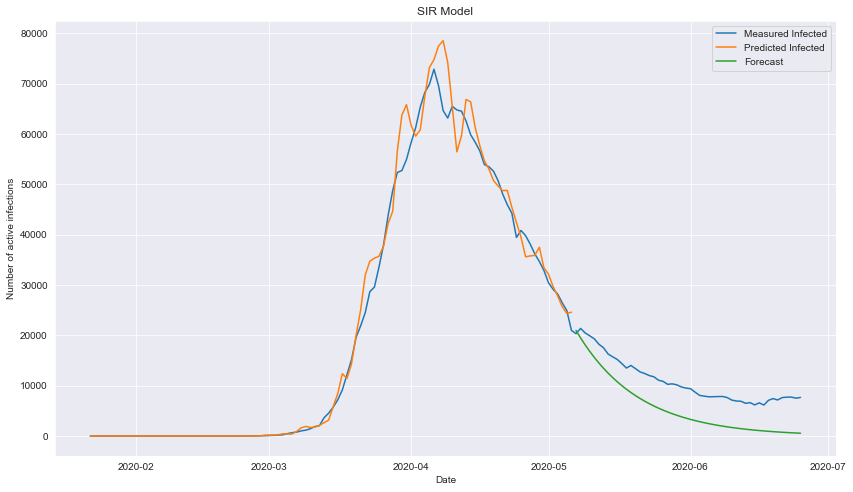

<Figure size 936x576 with 0 Axes>

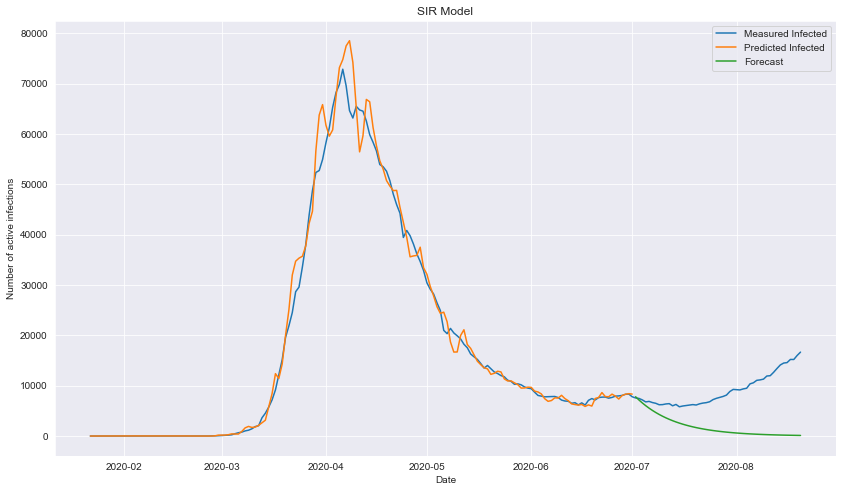

<Figure size 936x576 with 0 Axes>

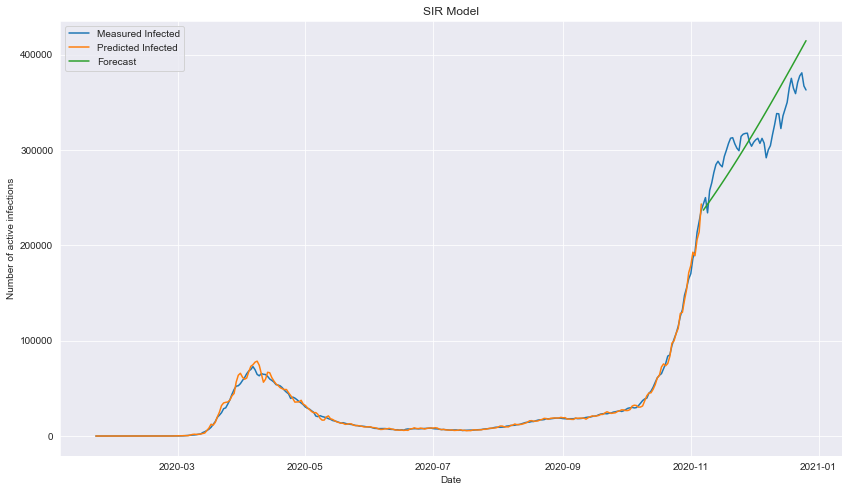

<Figure size 936x576 with 0 Axes>

In [435]:
#Test welches Fenster bei Vorhersage am besten
country = 'Germany'
end = [106, 162, 290]
for i in end:
    I, I_p = predictTime(country, 5, i)
    error = (I[i + 3] - I_p[i + 3]) / I[i + 3]
    #er = oneDayError(I[end[i]:end[i]+3], I_p[end[i]:end[i]+3])
    # print("predictTime: \n size:", i, "Fehler:", error)
    # I2, I_p2 = predictEveryday(country, 6, 250,260)
    # error2 = oneDayError(I2[250:260], I_p2[250:260])
    # print("predictEveryday: \n size:", i,"Fehler:",(1/10)*np.sum(abs(error2)))
#predictSomething(country, 5, 290)

In [436]:
#Auswertung

country = 'Germany'
#plotParam(country, 5, 450)
#predictI_bySize(country, 0, 5)
#predictFuture(country, 5, 1)
#I , I_p = predictTime(country, 5, 260)
#modelGermany(country, 5, 472, 0)
#error = oneDayError(I[250:260], I_p[250:260])
#print((1/10)*np.sum(abs(error)))
#I2, I_p2 = predictEveryday(country, 6, 250,260)
#error2 = oneDayError(I2[250:260], I_p2[250:260])
#print((1/10)*np.sum(abs(error2)))

In [437]:
# Versuch einfach I(t) vorherzusagen
# fun fact: funktioniert nicht
# size = 5
# t = 250
# I,R,D,C = load_IR(country,popu_dict[country],0)
# I_t_p,I_t_all = read_I_t(I,country,size)
# datasets_X = np.arange(0, t+50).reshape([t+50,1])
# I_new = predictParameter(datasets_X, I_t_p[:t])
# plt.figure()
# plt.plot(datasets_X[:t],I_t_p[:t], label="I aus Modell", linewidth=0.5)
# plt.plot(datasets_X, I_new, label='I predicted')
# plt.title('I(t)')
# plt.grid(True)


